# Gameified Logistics Modeled with Reinforcement Learning
*by Jason Curcio, December, 2024* 

# Introduction
I've always been very interested in optimizing logistics problems using machine learning. Not only to see if a model can do it as well as a human, but to see if there is some unintuitive method by which throughput can be improved. There are many YouTube videos of people creating models to play games like Pokemon, hide-and-seek, or tag. I want to do something similar with a game called mini-motorways. There is a 2D grid of playable space where markets and homes can spawn. A market will generate a 'trip' which can only be completed by connecting a home to a market with a road. A car will drive from the home to the market and back home to complete a full trip. The game gets significantly more difficult when a different color market spawns and roads must cross to complete trips.

My proposal was overambitious given our timeline and the amount of work required to fully recreate mini-motorways. Instead, I created a simplified version of the game where success is measured by a variety of metrics discussed below.

#### Environment Setup
1. 15x15 grid world
2. Each cell can be any of the following: empty, road, house, market body, or market entrance
3. Four different color groups (red, green, blue, purple)
##### Key Elements
1. Houses: Source points where cars originate
    - Each house holds 2 cars
3. Markets: Destination points that generate trip demands
4. Roads: Player-built pathways connecting houses to markets
5. Cars: Travel between matching colored houses and markets
#### Game Rules
##### Traffic System
1. Cars can only travel on roads
2. Each road tile supports two-way traffic (north-south and east-west)
    - Each lane can only hold 1 car
    - Cars must wait if their desired lane is occupied
3. Cars accelerate after waiting, with a brief delay
##### Trip Generation
1. Markets periodically generate trip demands
2. Cars spawn from houses matching the market's color
3. Houses have a cooldown period between car departures
4. Maximum of 50 roads can be placed
##### Market Mechanics
1. Each market has 4 parking spaces
2. Cars must wait if the market is at full capacity
3. Cars spend a fixed time at markets before returning home
4. Markets have entrance points where cars queue
##### Path Requirements
1. Valid paths must exist between houses and their matching colored markets
2. Paths must be continuous (no gaps)
3. Roads cannot be placed on markets or houses
4. Cars cannot travel diagonally

The goal is to create an efficient road network that minimizes traffic congestion while maximizing throughput between houses and their corresponding markets.

#### Let's begin by importing the required packages

In [26]:
%load_ext autoreload
%autoreload 2

import time
import random
from collections import deque, namedtuple
from dataclasses import dataclass
from typing import Tuple, Dict, Set
from concurrent.futures import ThreadPoolExecutor
import threading

import numpy as np
import pygame
import gym
from gym import spaces
import torch
import torch.nn as nn
import torch.optim as optim
import torch.multiprocessing as mp
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as animation
from IPython.display import display, clear_output

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Game Environment Specifications

The MiniMotorwaysEnv class is essentially the game code. I manually created an environment I thought would be challenging. I placed the houses on the opposite diagonal side of the board from their respective market. My goal was to force the agent to be creative in their road placements, and to create potential traffic in the middle of the board for the agent to resolve. Given more time, it would be interesting to see how different agents perform in different environments. Below is an image of the board I chose with roads randomly scattered:

![image info](initial_state.jpg)

Aside from containing the rules and game logic, it also tracks useful metrics used during the learning of our model:
#### Metrics Overview

##### Top-Level Metrics
- **Total Trips Completed** (`total_trips_completed`): *Integer*  
  The total number of trips successfully completed.
- **Average Trip Time** (`average_trip_time`): *Float*  
  The average time taken to complete a trip.
- **Traffic Conflicts** (`traffic_conflicts`): *Integer*  
  The number of traffic conflicts recorded.
- **Cars Waiting** (`cars_waiting`): *Integer*  
  The number of cars currently waiting.
- **Diagonal Efficiency** (`diagonal_efficiency`): *Float*  
  A metric indicating efficiency on diagonal routes.

##### Intersection Congestion
- **Intersection Congestion** (`intersection_congestion`): *Dictionary*  
  Contains details about congestion at intersections.

##### Road Costs
- **Total Length** (`road_costs['total_length']`): *Integer*  
  The total length of roads.
- **Turns** (`road_costs['turns']`): *Integer*  
  The total number of turns.
- **Crossings** (`road_costs['crossings']`): *Integer*  
  The total number of crossings.

##### Coverage Metrics
- **Houses Served** (`coverage_metrics['houses_served']`): *Set*  
  The set of houses served.
- **Markets Served** (`coverage_metrics['markets_served']`): *Set*  
  The set of markets served.
- **Dead Ends** (`coverage_metrics['dead_ends']`): *Integer*  
  The number of dead ends in the network.

##### Traffic Flow
- **Bottlenecks** (`traffic_flow['bottlenecks']`): *Set*  
  Locations identified as traffic bottlenecks.
- **Parallel Routes** (`traffic_flow['parallel_routes']`): *Integer*  
  The number of parallel routes available.
- **Route Redundancy** (`traffic_flow['route_redundancy']`): *Integer*  
  The redundancy in routing.

Model architecture and rewards are discussed further below.

In [27]:
@dataclass
class TileOccupancy:
    north_to_south: bool = False  # Traffic flowing from north to south
    south_to_north: bool = False  # Traffic flowing from south to north
    east_to_west: bool = False    # Traffic flowing from east to west
    west_to_east: bool = False    # Traffic flowing from west to east

class MarketSpace:
    def __init__(self, capacity=4):
        self.capacity = capacity
        self.cars = set()  # Set of cars currently at market
        
    def is_full(self):
        return len(self.cars) >= self.capacity
        
    def add_car(self, car_id):
        if not self.is_full():
            self.cars.add(car_id)
            return True
        return False
        
    def remove_car(self, car_id):
        if car_id in self.cars:
            self.cars.remove(car_id)
            return True
        return False

class MiniMotorwaysEnv(gym.Env):
    def __init__(self, grid_size=15, render_mode="external"):
        super(MiniMotorwaysEnv, self).__init__()
        
        self.grid_size = grid_size
        self.render_mode = render_mode
        self.observation_space = spaces.Box(0, 4, (grid_size, grid_size), dtype=np.int32)
        self.action_space = spaces.MultiDiscrete([self.grid_size, self.grid_size])
        
        # Game state variables
        self.house_last_departure = {}
        self.house_departure_delay = 0.1
        self.market_delay = 0.1
        self.market_spaces = {}
        self.car_counter = 0
        self.tile_occupancy = {}
        self.houses_available = {}
        self.trips = []
        self.cars = []
        self.market_entrances = []
        self.last_trip_time = time.time()
        self.movement_interval = 0.05
        self.acceleration_delay = 0.05
        self.trip_generation_interval = 0.1

        self.used_roads = set()  # Track which road tiles are being used
        
        # Metrics for RL evaluation
        self.metrics = {
            'total_trips_completed': 0,
            'average_trip_time': [],
            'traffic_conflicts': 0,
            'cars_waiting': 0,
            'diagonal_efficiency': [],
            'intersection_congestion': {},
            
            # New metrics for road quality
            'road_costs': {
                'total_length': 0,
                'turns': 0,
                'crossings': 0
            },
            'coverage_metrics': {
                'houses_served': set(),
                'markets_served': set(),
                'dead_ends': 0
            },
            'traffic_flow': {
                'bottlenecks': set(),
                'parallel_routes': 0,
                'route_redundancy': 0
            },
            'network_stats': {
                'connectivity_score': 0,
                'avg_route_options': 0,
                'isolated_segments': 0
            }
        }
        
        # Colors
        self.colors = {
            0: (255, 255, 255),  # empty
            1: (128, 128, 128),  # road
            'active_road': (180, 180, 180),  # active road (lighter gray)
        }
        
        self.house_market_colors = {
            0: (247, 57, 57),    # red
            1: (171, 247, 57),   # lime green
            2: (57, 247, 155),   # mint
            3: (57, 57, 247),    # blue
            4: (206, 57, 247)    # purple
        }
        
        self.car_colors = {
            0: (173, 40, 40),    # darker red
            1: (120, 173, 40),   # darker lime green
            2: (40, 173, 109),   # darker mint
            3: (40, 40, 173),    # darker blue
            4: (144, 40, 173),   # darker purple
        }
        
        # Color assignments
        self.house_colors = {}   # (x,y) -> color_idx
        self.market_colors = {}  # (x,y) -> color_idx
        
        # Don't initialize pygame display here
        pygame.init()
        self.font = pygame.font.Font(None, 36)
        self.running = True

    def reset(self):
        self.state = np.zeros((self.grid_size, self.grid_size), dtype=np.int32)
        self.market_entrances = []
        self.tile_occupancy = {}
        self.houses_available = {}
        self.house_last_departure = {}
        self.market_spaces = {}
        self.car_counter = 0
        self.house_colors = {}
        self.market_colors = {}
        self.running = True
        
        # Reset metrics
        self.metrics = {
            'total_trips_completed': 0,
            'average_trip_time': [],
            'traffic_conflicts': 0,
            'cars_waiting': 0,
            'diagonal_efficiency': [],
            'intersection_congestion': {}
        }
        
        # Place houses and markets with their colors
        red_houses = [(2, 2), (1, 1), (4, 2)]
        green_houses = [(2, 12), (3, 13), (4, 11)]
        blue_houses = [(13, 10), (14, 11), (14, 8)]
        purple_houses = [(12, 4), (13, 6), (11, 6)]
        
        all_houses = {
            0: red_houses,    # Red
            1: green_houses,  # Green
            3: blue_houses,   # Blue
            4: purple_houses  # Purple
        }
        
        for color_idx, houses in all_houses.items():
            for house in houses:
                self.state[house] = 2
                self.house_colors[house] = color_idx
                self.houses_available[house] = 2
                self.house_last_departure[house] = 0
        
        # Place markets
        market_positions = [
            (10, 10),  # Red
            (10, 2),   # Green
            (2, 3),    # Blue
            (2, 8)     # Purple
        ]
        
        for i, pos in enumerate(market_positions):
            color_idx = [0, 1, 3, 4][i]
            self._place_market(pos[0], pos[1], color_idx)
        
        # Define key intersection points
        self.key_intersections = [(7, 7), (7, 8), (8, 7), (8, 8)]
        for point in self.key_intersections:
            self.metrics['intersection_congestion'][point] = 0
        
        self.trips = []
        self.cars = []
        self.last_trip_time = time.time()
        
        return self.state

    def step_batch(self, num_steps=10):
        """Process multiple simulation steps at once"""
        total_reward = 0
        info = None
        
        for _ in range(num_steps):
            next_state, reward, done, step_info = self.step()
            total_reward += reward
            info = step_info  # Keep the last step's info
            
            if done:
                break
                
        return next_state, total_reward/num_steps, done, info

    def update_used_roads(self):
        self.used_roads.clear()
        # Check all house-market pairs
        for house_pos in self.houses_available.keys():
            house_color = self.house_colors[house_pos]
            for market in self.market_entrances:
                if market["color_idx"] == house_color:
                    path = self.find_path(house_pos, market["position"])
                    if path:
                        # Add all road positions in the path to used_roads
                        self.used_roads.update(path)
    
    def analyze_road_layout(self):
        """Analyze the current road layout for various quality metrics"""
        roads = np.where(self.state == 1)
        road_positions = set(zip(roads[0], roads[1]))
        
        # Calculate road network properties
        self.metrics['road_costs']['total_length'] = len(road_positions)
        self.metrics['road_costs']['turns'] = self._count_turns(road_positions)
        self.metrics['road_costs']['crossings'] = self._count_intersections(road_positions)
        
        self._analyze_coverage(road_positions)
        self._analyze_traffic_flow(road_positions)
        self._calculate_network_stats(road_positions)

    def _count_turns(self, road_positions):
        """Count number of turns in the road network"""
        turns = 0
        for x, y in road_positions:
            connected = [(x+dx, y+dy) for dx, dy in [(0,1), (0,-1), (1,0), (-1,0)]
                        if (x+dx, y+dy) in road_positions]
            if len(connected) == 2:
                # Check if connected roads form a turn (not straight)
                dx = connected[1][0] - connected[0][0]
                dy = connected[1][1] - connected[0][1]
                if dx != 0 and dy != 0:
                    turns += 1
        return turns

    def _count_intersections(self, road_positions):
        """Count number of road intersections"""
        intersections = 0
        for x, y in road_positions:
            connected = sum(1 for dx, dy in [(0,1), (0,-1), (1,0), (-1,0)]
                          if (x+dx, y+dy) in road_positions)
            if connected > 2:
                intersections += 1
        return intersections

    def _analyze_coverage(self, road_positions):
        """Analyze how well roads cover houses and markets"""
        houses_served = set()
        markets_served = set()
        dead_ends = 0
        
        # Check coverage for houses and markets
        for x, y in road_positions:
            # Check adjacent cells for houses and markets
            for dx, dy in [(0,1), (0,-1), (1,0), (-1,0)]:
                nx, ny = x + dx, y + dy
                if 0 <= nx < self.grid_size and 0 <= ny < self.grid_size:
                    if self.state[nx, ny] == 2:  # House
                        houses_served.add((nx, ny))
                    elif self.state[nx, ny] in [3, 4]:  # Market or entrance
                        markets_served.add((nx, ny))
            
            # Check for dead ends
            connected = sum(1 for dx, dy in [(0,1), (0,-1), (1,0), (-1,0)]
                          if (x+dx, y+dy) in road_positions)
            if connected == 1:
                dead_ends += 1
        
        self.metrics['coverage_metrics']['houses_served'] = houses_served
        self.metrics['coverage_metrics']['markets_served'] = markets_served
        self.metrics['coverage_metrics']['dead_ends'] = dead_ends
    
    def _analyze_traffic_flow(self, road_positions):
        """Analyze traffic flow characteristics"""
        bottlenecks = set()
        parallel_routes = 0
        
        # Identify bottlenecks (critical paths)
        for x, y in road_positions:
            connected = sum(1 for dx, dy in [(0,1), (0,-1), (1,0), (-1,0)]
                          if (x+dx, y+dy) in road_positions)
            if connected == 2:
                # Check if this is the only path between two areas
                if self._is_critical_path((x, y), road_positions):
                    bottlenecks.add((x, y))
        
        # Count parallel routes between key points
        for house in self.houses_available:
            for market in self.market_entrances:
                parallel_routes += self._count_distinct_paths(
                    house, 
                    market['position'], 
                    road_positions
                )
        
        self.metrics['traffic_flow']['bottlenecks'] = bottlenecks
        self.metrics['traffic_flow']['parallel_routes'] = parallel_routes
        
    def _is_critical_path(self, pos, road_positions):
        """Check if removing this road would disconnect the network"""
        test_positions = road_positions - {pos}
        if not test_positions:
            return False
            
        # Pick a starting point
        start = next(iter(test_positions))
        connected = self._flood_fill(start, test_positions)
        
        return len(connected) < len(test_positions)
    
    def _flood_fill(self, start, valid_positions):
        """Find all connected positions using flood fill"""
        seen = {start}
        queue = [start]
        
        while queue:
            x, y = queue.pop(0)
            for dx, dy in [(0,1), (0,-1), (1,0), (-1,0)]:
                next_pos = (x+dx, y+dy)
                if next_pos in valid_positions and next_pos not in seen:
                    seen.add(next_pos)
                    queue.append(next_pos)
        
        return seen
    
    def _count_distinct_paths(self, start, end, road_positions, max_paths=3):
        """Count number of significantly different paths between points"""
        paths = []
        for _ in range(max_paths):
            path = self.find_path(start, end)
            if not path:
                break
                
            paths.append(path)
            # Temporarily remove this path to find alternatives
            road_positions = road_positions - set(path)
            
        return len(paths)
    
    def _calculate_network_stats(self, road_positions):
        """Calculate overall network statistics"""
        # Connectivity score based on ratio of actual to possible connections
        total_positions = len(road_positions)
        if total_positions > 0:
            total_connections = sum(sum(1 for dx, dy in [(0,1), (0,-1), (1,0), (-1,0)]
                                      if (x+dx, y+dy) in road_positions)
                                  for x, y in road_positions)
            self.metrics['network_stats']['connectivity_score'] = total_connections / (4 * total_positions)
        
        # Average route options from each intersection
        intersections = [(x, y) for x, y in road_positions if 
                        sum(1 for dx, dy in [(0,1), (0,-1), (1,0), (-1,0)]
                            if (x+dx, y+dy) in road_positions) > 2]
        if intersections:
            avg_routes = sum(self._count_route_options(pos, road_positions) 
                           for pos in intersections) / len(intersections)
            self.metrics['network_stats']['avg_route_options'] = avg_routes
        
        # Count isolated road segments
        self.metrics['network_stats']['isolated_segments'] = self._count_isolated_segments(road_positions)

    def calculate_placement_reward(self, state, action, next_state):
        """Calculate immediate reward for road placement"""
        reward = 0
        row = action // self.grid_size
        col = action % self.grid_size
        
        # Reward for connecting to houses/markets directly
        connects_to_important = False
        for dr, dc in [(0, 1), (0, -1), (1, 0), (-1, 0)]:
            nr, nc = row + dr, col + dc
            if (0 <= nr < self.grid_size and 
                0 <= nc < self.grid_size and 
                state[nr, nc] in [2, 3, 4]):  # House or market
                connects_to_important = True
                reward += 5.0  # Strong immediate reward
                break
        
        # Regular connectivity reward
        connections = 0
        for dr, dc in [(0, 1), (0, -1), (1, 0), (-1, 0)]:
            nr, nc = row + dr, col + dc
            if (0 <= nr < self.grid_size and 
                0 <= nc < self.grid_size and 
                state[nr, nc] in [1, 2, 3, 4]):
                connections += 1
        
        if connections == 0:
            reward -= 10.0  # Punish isolated roads
        elif not connects_to_important:
            reward += connections * 1.0  # Smaller reward for regular connections
        
        return reward

    def get_road_cells(self, state):
        """Get coordinates of all road cells"""
        return [(r, c) for r in range(len(state)) 
                for c in range(len(state[0])) 
                if state[r, c] == 1]

    def has_valid_path(self, state, start, end):
        """Check if there's a valid path between two points"""
        # Simple BFS implementation
        queue = deque([(start)])
        seen = {start}
        
        while queue:
            current = queue.popleft()
            if current == end:
                return True
                
            for dr, dc in [(0, 1), (0, -1), (1, 0), (-1, 0)]:
                nr, nc = current[0] + dr, current[1] + dc
                next_pos = (nr, nc)
                
                if (0 <= nr < len(state) and 
                    0 <= nc < len(state[0]) and 
                    next_pos not in seen and
                    state[nr, nc] in [1, 2, 3, 4]):  # Road or building
                    queue.append(next_pos)
                    seen.add(next_pos)
        
        return False
    
    def _count_route_options(self, pos, road_positions):
        """Count number of unique routes available from an intersection"""
        x, y = pos
        options = 0
        for dx, dy in [(0,1), (0,-1), (1,0), (-1,0)]:
            if (x+dx, y+dy) in road_positions:
                options += 1
        return options
    
    def _count_isolated_segments(self, road_positions):
        """Count number of disconnected road networks"""
        if not road_positions:
            return 0
            
        segments = 0
        remaining = set(road_positions)
        
        while remaining:
            start = next(iter(remaining))
            connected = self._flood_fill(start, remaining)
            remaining -= connected
            segments += 1
            
        return segments
    
    def _calculate_reward(self):
        """Calculate reward based on active cars and traffic"""
        reward = 0
        
        # Major reward for active cars
        active_cars = sum(1 for car in self.cars if not car["completed"])
        reward += active_cars * 15.0  # Strong positive reward for active cars
        
        # Small penalty for traffic conflicts
        traffic_penalty = self.metrics['traffic_conflicts'] * 2.0
        # Cap traffic penalty to never outweigh active cars
        traffic_penalty = min(traffic_penalty, active_cars * 5.0)
        reward -= traffic_penalty
        
        # Small penalty for waiting cars
        waiting_penalty = self.metrics['cars_waiting'] * 1.0
        reward -= waiting_penalty
        
        return reward
    
    def _place_market(self, row, col, color_idx):
        # Place market blocks
        for r in range(2):
            for c in range(2):
                self.state[row+r, col+c] = 3
                self.market_colors[(row+r, col+c)] = color_idx
        
        # Place entrance
        entrance_pos = (row, col+2)
        self.state[entrance_pos] = 4
        self.market_colors[entrance_pos] = color_idx
        self.market_entrances.append({
            "position": entrance_pos,
            "pending_trips": 0,
            "color_idx": color_idx
        })
        self.market_spaces[entrance_pos] = MarketSpace(capacity=4)

    def get_interpolated_position(self, car, current_time):
        """Calculate smooth position between tiles"""
        if "move_start_time" not in car or "prev_pos" not in car:
            return car["position"][0], car["position"][1]
        
        # Calculate progress of movement (0 to 1)
        progress = min((current_time - car["move_start_time"]) / self.movement_interval, 1.0)
        
        prev_x, prev_y = car["prev_pos"]
        curr_x, curr_y = car["position"]
        
        # Linear interpolation between previous and current position
        x = prev_x + (curr_x - prev_x) * progress
        y = prev_y + (curr_y - prev_y) * progress
        
        return x, y
    
    def get_lane_offset(self, current_pos, prev_pos, next_pos=None):
        """Calculate lane offset based on movement direction, handling turns properly"""
        cell_size = self.screen.get_width() // self.grid_size
        offset = cell_size // 4
        
        curr_x, curr_y = current_pos
        prev_x, prev_y = prev_pos
        
        # Calculate current direction
        dx = curr_x - prev_x
        dy = curr_y - prev_y
        
        # If we're in a turn (have next position and it's a different direction)
        if next_pos:
            next_x, next_y = next_pos
            next_dx = next_x - curr_x
            next_dy = next_y - curr_y
            
            # If turning (current direction is different from next direction)
            if (dx != 0 and next_dy != 0) or (dy != 0 and next_dx != 0):
                # Use current direction for offset until halfway through tile
                return (-offset if dx > 0 else offset, 0) if abs(dx) > abs(dy) else (0, offset if dy > 0 else -offset)
        
        # Normal straight movement
        if abs(dx) > abs(dy):  # Moving vertically
            return (-offset if dx > 0 else offset, 0)
        else:  # Moving horizontally
            return (0, offset if dy > 0 else -offset)
            
    def is_tile_available(self, pos, next_pos):
        """Check if a tile is available based on direction of travel"""
        if self.state[next_pos] in [2, 4]:  # Always allow entry to houses and market entrances
            return True
            
        occupancy = self.tile_occupancy.get(next_pos, TileOccupancy())
        dx = next_pos[0] - pos[0]
        dy = next_pos[1] - pos[1]
        
        if abs(dx) > abs(dy):  # Vertical movement
            return not occupancy.north_to_south if dx > 0 else not occupancy.south_to_north
        else:  # Horizontal movement
            return not occupancy.west_to_east if dy > 0 else not occupancy.east_to_west

    def occupy_tile(self, pos, prev_pos, next_pos=None):  # Added next_pos parameter with default None
        """Mark appropriate lane as occupied"""
        if self.state[pos] in [2, 4]:
            return
                
        if pos not in self.tile_occupancy:
            self.tile_occupancy[pos] = TileOccupancy()
                
        dx = pos[0] - prev_pos[0]
        dy = pos[1] - prev_pos[1]
            
        if abs(dx) > abs(dy):
            if dx > 0:
                self.tile_occupancy[pos].north_to_south = True
            else:
                self.tile_occupancy[pos].south_to_north = True
        else:
            if dy > 0:
                self.tile_occupancy[pos].west_to_east = True
            else:
                self.tile_occupancy[pos].east_to_west = True

    def release_tile(self, pos, prev_pos):
        """Release occupied lane"""
        if self.state[pos] in [2, 4] or pos not in self.tile_occupancy:
            return
            
        dx = pos[0] - prev_pos[0]
        dy = pos[1] - prev_pos[1]
        
        if abs(dx) > abs(dy):
            if dx > 0:
                self.tile_occupancy[pos].north_to_south = False
            else:
                self.tile_occupancy[pos].south_to_north = False
        else:
            if dy > 0:
                self.tile_occupancy[pos].west_to_east = False
            else:
                self.tile_occupancy[pos].east_to_west = False

    @staticmethod
    def manhattan_distance(pos1, pos2):
        """Calculate Manhattan distance between two points"""
        return abs(pos1[0] - pos2[0]) + abs(pos1[1] - pos2[1])

    def find_closest_available_house(self, market_pos):
        """Find closest house with available cars that matches market color"""
        market_color = self.market_colors[market_pos]
        houses = [(pos, self.houses_available[pos]) for pos in self.houses_available.keys() 
                 if self.house_colors[pos] == market_color]
        houses_with_cars = [(pos, cars) for pos, cars in houses if cars > 0]
        
        if not houses_with_cars:
            return None
            
        sorted_houses = sorted(houses_with_cars, 
                             key=lambda x: self.manhattan_distance(x[0], market_pos))
        
        for house_pos, _ in sorted_houses:
            if self.find_path(house_pos, market_pos):
                return house_pos
                
        return None

    def can_dispatch_from_house(self, house_pos, current_time):
        """Check if enough time has passed since the last car departed from this house"""
        last_departure = self.house_last_departure.get(house_pos, 0)
        return (current_time - last_departure) >= self.house_departure_delay

    def generate_trip(self):
        """Generate new trips at markets"""
        for market in self.market_entrances:
            market_pos = market["position"]
            market["pending_trips"] += 1

    def try_assign_pending_trips(self):
        current_time = time.time()
        
        for market in self.market_entrances:
            while market["pending_trips"] > 0:
                closest_house = self.find_closest_available_house(market["position"])
                if (closest_house and 
                    self.houses_available[closest_house] > 0 and 
                    self.can_dispatch_from_house(closest_house, current_time)):
                    
                    path = self.find_path(closest_house, market["position"])
                    if path:
                        self.houses_available[closest_house] -= 1
                        self.house_last_departure[closest_house] = current_time
                        self.car_counter += 1
                        car_id = self.car_counter
                        
                        print(f"Assigning trip from house {closest_house} to market {market['position']}")
                        self.cars.append({
                            "id": car_id,
                            "position": closest_house,
                            "path": list(path),
                            "completed": False,
                            "returning": False,
                            "last_move_time": current_time,
                            "home": closest_house,
                            "market": market["position"],
                            "waiting": False,
                            "start_time": current_time  # Added this line
                        })
                        market["pending_trips"] -= 1
                    else:
                        break
                else:
                    break

    def update_cars(self):
        """Update car positions and states with improved movement and acceleration logic"""
        current_time = time.time()
        for car in self.cars:
            if car["completed"]:
                continue
    
            # Initialize previous position if needed
            if "prev_pos" not in car:
                car["prev_pos"] = car["position"]
                car["move_start_time"] = current_time
    
            # Handle market arrival
            if not car.get("returning", False) and car["position"] == car["market"]:
                market_space = self.market_spaces[car["market"]]
                
                if "market_arrival_time" not in car:
                    if not market_space.is_full():
                        market_space.add_car(car["id"])
                        car["market_arrival_time"] = current_time
                        car["at_market"] = True
                    else:
                        car["waiting"] = True
                    continue
                    
                if current_time - car["market_arrival_time"] >= self.market_delay:
                    return_path = self.find_path(car["position"], car["home"])
                    if return_path:
                        market_space.remove_car(car["id"])
                        car["path"] = list(return_path)
                        car["returning"] = True
                        car["at_market"] = False
                        del car["market_arrival_time"]
                continue
    
            # Handle waiting at full market
            if car["waiting"] and not car.get("returning", False) and car["position"] == car["market"]:
                market_space = self.market_spaces[car["market"]]
                if not market_space.is_full():
                    car["waiting"] = False
                    market_space.add_car(car["id"])
                    car["market_arrival_time"] = current_time
                    car["at_market"] = True
                continue
    
            # Handle movement and acceleration
            if car["path"]:
                next_pos = car["path"][0]
                should_move = False
    
                # If car is waiting, check if it can accelerate
                if car["waiting"]:
                    if "wait_start_time" not in car:
                        car["wait_start_time"] = current_time
                        car["accelerated"] = False
    
                    wait_duration = current_time - car["wait_start_time"]
                    
                    # Check if we can move now
                    if self.is_tile_available(car["position"], next_pos):
                        if wait_duration >= self.acceleration_delay:
                            car["waiting"] = False
                            car["accelerated"] = True
                            should_move = True
                        elif not car.get("accelerated", False):
                            should_move = current_time - car["last_move_time"] >= self.movement_interval
                else:
                    # Normal movement check
                    should_move = current_time - car["last_move_time"] >= self.movement_interval
    
                # Perform movement if conditions are met
                if should_move and self.is_tile_available(car["position"], next_pos):
                    # Get the position after next (if any) for turning calculations
                    next_next_pos = car["path"][1] if len(car["path"]) > 1 else None
                    
                    self.release_tile(car["position"], car["prev_pos"])
                    car["prev_pos"] = car["position"]
                    car["position"] = car["path"].pop(0)
                    car["move_start_time"] = current_time
                    car["last_move_time"] = current_time
                    car["waiting"] = False
                    
                    if "wait_start_time" in car:
                        del car["wait_start_time"]
                    if "accelerated" in car:
                        del car["accelerated"]
                    
                    self.occupy_tile(car["position"], car["prev_pos"], next_next_pos)
                    
                    if car.get("returning", False) and not car["path"]:
                        self.houses_available[car["home"]] += 1
                        car["completed"] = True
                        self.release_tile(car["position"], car["prev_pos"])
                elif not car["waiting"] and not self.is_tile_available(car["position"], next_pos):
                    car["waiting"] = True
                    car["wait_start_time"] = current_time

    def render(self, surface=None):
        """Render the environment to the given surface"""
        if not self.running:
            return
            
        # If no surface provided, render to self.screen
        target_surface = surface if surface is not None else self.screen
        
        # Clear the surface
        target_surface.fill(self.colors[0])
        
        cell_size = target_surface.get_width() // self.grid_size
        current_time = time.time()

        self.update_used_roads()
        
        # Draw grid elements
        for row in range(self.grid_size):
            for col in range(self.grid_size):
                cell_value = self.state[row, col]
                if cell_value == 1:  # Road
                    if (row, col) in self.used_roads:
                        color = self.colors['active_road']  # Use lighter color for active roads
                    else:
                        color = self.colors[1]  # Use regular road color
                elif cell_value == 0:
                    color = self.colors[0]
                elif cell_value == 2:  # House
                    color = self.house_market_colors[self.house_colors.get((row, col), 0)]
                elif cell_value in [3, 4]:  # Market or entrance
                    color = self.house_market_colors[self.market_colors.get((row, col), 0)]
                
                pygame.draw.rect(
                    target_surface,
                    color,
                    pygame.Rect(col * cell_size, row * cell_size, cell_size, cell_size)
                )
                pygame.draw.rect(
                    target_surface,
                    (0, 0, 0),
                    pygame.Rect(col * cell_size, row * cell_size, cell_size, cell_size),
                    1
                )
        
        # Draw cars
        for car in self.cars:
            if not car.get("completed", False):
                pos_x, pos_y = self.get_interpolated_position(car, current_time)
                next_pos = car["path"][0] if car["path"] else None
                offset_x, offset_y = self.get_lane_offset(car["position"], car["prev_pos"], next_pos)
                
                screen_x = pos_y * cell_size + cell_size // 2 + offset_x
                screen_y = pos_x * cell_size + cell_size // 2 + offset_y
                
                color_idx = self.house_colors[car["home"]]
                pygame.draw.circle(
                    target_surface,
                    self.car_colors[color_idx],
                    (screen_x, screen_y),
                    cell_size // 4
                )
        
        # Draw market information
        for market in self.market_entrances:
            pos = market["position"]
            market_space = self.market_spaces[pos]
            text = f"{len(market_space.cars)}/{market_space.capacity}"
            if market["pending_trips"] > 0:
                text += f" (+{market['pending_trips']})"
            
            text_surface = self.font.render(text, True, (0, 0, 0))
            text_rect = text_surface.get_rect(center=(
                pos[1] * cell_size + cell_size // 2,
                pos[0] * cell_size + cell_size // 2
            ))
            pygame.draw.rect(target_surface, (255, 255, 255), text_rect)
            target_surface.blit(text_surface, text_rect)

    def step(self, action=None):
        current_time = time.time()
        if current_time - self.last_trip_time >= self.trip_generation_interval:
            self.generate_trip()
            self.last_trip_time = current_time
    
        self.try_assign_pending_trips()
        
        # Track intersection congestion
        for point in self.key_intersections:
            cars_at_intersection = sum(1 for car in self.cars 
                                     if not car["completed"] and car["position"] == point)
            self.metrics['intersection_congestion'][point] = cars_at_intersection
        
        # Track waiting cars
        self.metrics['cars_waiting'] = sum(1 for car in self.cars 
                                         if not car["completed"] and car.get("waiting", False))
        
        # Track traffic conflicts
        self.metrics['traffic_conflicts'] = sum(1 for pos, occupancy in self.tile_occupancy.items()
            if sum([occupancy.north_to_south, occupancy.south_to_north,
                   occupancy.east_to_west, occupancy.west_to_east]) > 1)
    
        self.update_cars()
        
        # Clean up completed trips and update metrics
        completed_cars = [car for car in self.cars if car["completed"]]
        self.cars = [car for car in self.cars if not car["completed"]]
        
        for car in completed_cars:
            self.metrics['total_trips_completed'] += 1
            
            # Update trip time metrics
            if 'start_time' in car:
                trip_time = time.time() - car['start_time']
                self.metrics['average_trip_time'].append(trip_time)
                
                # Calculate diagonal efficiency
                start = car['home']
                end = car['market']
                optimal_distance = abs(end[0] - start[0]) + abs(end[1] - start[1])
                actual_distance = len(car.get('path', [])) + 1
                efficiency = optimal_distance / actual_distance if actual_distance > 0 else 0
                self.metrics['diagonal_efficiency'].append(efficiency)
        
        # Calculate reward based on metrics
        reward = self._calculate_reward()
        
        done = False
        info = {
            'metrics': {
                'total_trips_completed': self.metrics['total_trips_completed'],
                'average_trip_time': sum(self.metrics['average_trip_time']) / len(self.metrics['average_trip_time']) 
                                   if self.metrics['average_trip_time'] else 0,
                'traffic_conflicts': self.metrics['traffic_conflicts'],
                'cars_waiting': self.metrics['cars_waiting'],
                'diagonal_efficiency': sum(self.metrics['diagonal_efficiency']) / len(self.metrics['diagonal_efficiency'])
                                     if self.metrics['diagonal_efficiency'] else 0,
            }
        }
        
        return self.state, reward, done, info

    def find_path(self, start, goal):
        """Find path from start to goal using BFS"""
        queue = deque([[start]])
        seen = set([start])
        
        while queue:
            path = queue.popleft()
            current = path[-1]
            x, y = current
            
            if current == goal:
                return path[1:]  # Exclude the starting position
            
            for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                nx, ny = x + dx, y + dy
                next_pos = (nx, ny)
                
                if (0 <= nx < self.grid_size and 
                    0 <= ny < self.grid_size and 
                    next_pos not in seen):
                    
                    cell_value = self.state[nx, ny]
                    
                    can_move = (
                        cell_value == 1 or  # Road
                        next_pos == goal     # Goal position
                    )
                    
                    # Prevent using market tiles as roads
                    if cell_value == 3:
                        continue
                        
                    # Only allow entering market entrance if it's the goal
                    if cell_value == 4 and next_pos != goal:
                        continue
                    
                    if can_move:
                        queue.append(path + [next_pos])
                        seen.add(next_pos)
        
        return None  # No path found

    def _calculate_reward(self):
        """Calculate reward based on various metrics"""
        reward = 0
        
        # Positive reward for completed trips
        reward += self.metrics['total_trips_completed'] * 10
        
        # Negative reward for waiting cars
        reward -= self.metrics['cars_waiting'] * 2
        
        # Negative reward for intersection congestion
        for congestion in self.metrics['intersection_congestion'].values():
            reward -= congestion * 3
        
        # Efficiency bonus
        if self.metrics['diagonal_efficiency']:
            avg_efficiency = sum(self.metrics['diagonal_efficiency']) / len(self.metrics['diagonal_efficiency'])
            reward += avg_efficiency * 20
        
        # Time efficiency bonus
        if self.metrics['average_trip_time']:
            avg_time = sum(self.metrics['average_trip_time']) / len(self.metrics['average_trip_time'])
            reward += max(0, 100 - avg_time)
            
        return reward

    def close(self):
        pygame.quit()

# Methods
#### Architecture
The following cell contains the code for the reinforcement learning agent. I decided to use a CNN to process the game state and predict Q-values for each possible action. The input to the model is a multi-channel representation of the game grid, with separate channels for empty spaces, roads, houses, markets, and market entrances. The CNN consists of three convolutional layers followed by two fully connected layers. The output of the model is a vector of Q-values, one for each possible road placement action which the DQN uses..

#### Reward Function
$R_{total} = w_p \cdot R_{placement} + w_e \cdot R_{performance}$

- $R_{total}$ is the total reward for the episode
- $R_{placement}$ is the cumulative placement reward during the road placement phase
- $R_{performance}$ is the average performance reward obtained during the evaluation phase
- $w_p$ and $w_e$ are the weights assigned to the placement reward and performance reward, respectively

##### Placement Reward
$R_{placement} = R_{tendril} + R_{intersection} + R_{goal} + R_{isolation}$

- $R_{tendril}$ is the reward for extending roads linearly (tendril-like growth)
    - $R_{tendril} = 15$ if the new road extends an existing path towards a goal (house or market)
    - $R_{tendril} = 10$ if the new road maintains a straight line with existing roads
    - $R_{tendril} = 8$ if the new road is the only connection to an existing road
- $R_{intersection}$ is the penalty for creating intersections
    - $R_{intersection} = -20 \cdot (n_{adjacent} - 2)$ if the number of adjacent roads $n_{adjacent}$ is greater than 2
- $R_{goal}$ is the reward for connecting to houses or markets
    - $R_{goal} = 15$ for each adjacent house or market
- $R_{isolation}$ is the penalty for isolated roads
    - $R_{isolation} = -25$ if the new road has no adjacent roads and doesn't create a valid path



##### Performance Reward
$R_{performance} = R_{trips} + R_{conflicts} + R_{waiting} + R_{efficiency}$

- $R_{trips}$ is the reward for completed trips
    - $R_{trips} = 2 \cdot n_{trips}$, where $n_{trips}$ is the number of completed trips
- $R_{conflicts}$ is the penalty for traffic conflicts
    - $R_{conflicts} = -1.5 \cdot n_{conflicts}$, where $n_{conflicts}$ is the number of traffic conflicts
- $R_{waiting}$ is the penalty for waiting cars
    - $R_{waiting} = -1 \cdot n_{waiting}$, where $n_{waiting}$ is the number of waiting cars
- $R_{efficiency}$ is the reward for diagonal efficiency
    - $R_{efficiency} = 5 \cdot e_{diagonal}$, where $e_{diagonal}$ is the diagonal efficiency metric


The performance reward is averaged over the number of evaluation steps to obtain $R_{performance}$.

##### Coverage Reward
$R_{coverage} = 20 \cdot n_{valid} \cdot (1 + 0.5 \cdot (n_{valid} - 1)) - 10 \cdot \mathbb{1}{n{valid}=0}$

- $n_{valid}$ is the number of valid paths between houses and their corresponding markets
- $\mathbb{1}{n{valid}=0}$ is an indicator function that equals 1 if there are no valid paths, and 0 otherwise

The coverage reward provides a base reward of 20 for each valid path, with an additional 50% bonus for each additional valid path beyond the first one. If there are no valid paths, a penalty of -10 is applied.

#### My Decision Making
I noticed very early on that the agent was making very little progress over many epochs, so I slowly began adding more metrics to the reward function. I really wanted to encourage tendril-like roads, because a basic reward structure caused the agent to place very 'blocky' road networks. I also found that it wasn't enough to just reward performance; I had to reward placement, otherwise it took 100,000+ epochs to converge on a valid path. Additionally, I wanted to reward the agent placing roads next to houses and markets. Since the goal is to make as many trips as possible, this is a useful metric to encourage. Similarly, penalizing isolated roads enhances that behavior to discourage blobs of roads around houses and markets. Finally, I greatly reward the agent when a new valid path is created and provide a bonus for each additional valid path. I want the cars to have as many paths available as possible.

In [28]:
# Experience replay memory tuple
Experience = namedtuple('Experience', 
    ('state', 'action', 'next_state', 'reward', 'done'))

class RoadNetworkCNN(nn.Module):
    def __init__(self, input_channels, grid_size, action_size):
        super(RoadNetworkCNN, self).__init__()
        
        # Input shape: (batch_size, input_channels, grid_size, grid_size)
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        
        # Calculate the size of flattened features
        conv_output_size = grid_size * grid_size * 64
        
        self.fc1 = nn.Linear(conv_output_size, 512)
        self.fc2 = nn.Linear(512, action_size)
        
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # Convolutional layers
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Fully connected layers
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

class RoadPlacementDQN:
    def __init__(self, env, config):
        self.env = env
        self.config = config
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # Initialize networks
        self.policy_net = RoadNetworkCNN(
            input_channels=5,  # Empty, Road, House, Market, Market Entrance
            grid_size=env.grid_size,
            action_size=env.grid_size * env.grid_size  # One action per grid cell
        ).to(self.device)
        
        self.target_net = RoadNetworkCNN(
            input_channels=5,
            grid_size=env.grid_size,
            action_size=env.grid_size * env.grid_size
        ).to(self.device)
        
        # Copy policy net weights to target net
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        
        # Initialize optimizer
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=config['learning_rate'])
        
        # Initialize replay memory
        self.memory = deque(maxlen=config['memory_size'])
        
        # Initialize step counter for target network update
        self.steps_done = 0

        self.successful_patterns = []
        self.pattern_rewards = []
        self.success_streak = 0  # Track consecutive successful episodes
        self.base_epsilon = config['epsilon_start']  # Store original epsilon
        
    def preprocess_state(self, state):
        """Convert state to one-hot encoded channels"""
        channels = np.zeros((5, self.env.grid_size, self.env.grid_size))
        
        # Channel 0: Empty spaces
        channels[0] = (state == 0).astype(np.float32)
        # Channel 1: Roads
        channels[1] = (state == 1).astype(np.float32)
        # Channel 2: Houses
        channels[2] = (state == 2).astype(np.float32)
        # Channel 3: Markets
        channels[3] = (state == 3).astype(np.float32)
        # Channel 4: Market entrances
        channels[4] = (state == 4).astype(np.float32)
        
        return torch.FloatTensor(channels).unsqueeze(0).to(self.device)

    def calculate_placement_reward(self, state, action, next_state):
        """Heavily modified reward calculation to strongly encourage tendril-like growth"""
        reward = 0
        row = action // self.env.grid_size
        col = action % self.env.grid_size
        pos = (row, col)
        
        # Count adjacent and diagonal roads
        adjacent_positions = [(0, 1), (0, -1), (1, 0), (-1, 0)]
        diagonal_positions = [(1, 1), (1, -1), (-1, 1), (-1, -1)]
        
        adjacent_roads = 0
        adjacent_road_positions = []
        diagonal_roads = 0
        
        for dr, dc in adjacent_positions:
            nr, nc = row + dr, col + dc
            if (0 <= nr < self.env.grid_size and 
                0 <= nc < self.env.grid_size and 
                state[nr, nc] == 1):
                adjacent_roads += 1
                adjacent_road_positions.append((nr, nc))
        
        for dr, dc in diagonal_positions:
            nr, nc = row + dr, col + dc
            if (0 <= nr < self.env.grid_size and 
                0 <= nc < self.env.grid_size and 
                state[nr, nc] == 1):
                diagonal_roads += 1
        
        # Extremely harsh penalty for having more than 2 adjacent roads
        if adjacent_roads > 2:
            reward -= 20.0 * (adjacent_roads - 2)
        
        # Harsh penalty for any diagonal roads
        reward -= 10.0 * diagonal_roads
        
        # Check if this road extends an existing path linearly
        extends_linearly = False
        if adjacent_roads == 1 or adjacent_roads == 2:
            # For roads with one connection, check if it's moving towards a goal
            if adjacent_roads == 1:
                # Get direction of growth
                dr = row - adjacent_road_positions[0][0]
                dc = col - adjacent_road_positions[0][1]
                
                # Check if this direction points towards any house or market
                for house_pos in self.env.houses_available.keys():
                    house_color = self.env.house_colors[house_pos]
                    for market in self.env.market_entrances:
                        if market["color_idx"] == house_color:
                            market_pos = market["position"]
                            # Check if growing in roughly the right direction
                            if (dr * (market_pos[0] - row) >= 0 and 
                                dc * (market_pos[1] - col) >= 0):
                                extends_linearly = True
                                reward += 15.0  # Strong bonus for growing towards goals
                                break
                    if extends_linearly:
                        break
            
            # For roads with two connections, check if they form a straight line
            elif adjacent_roads == 2:
                pos1, pos2 = adjacent_road_positions
                if pos1[0] == pos2[0] or pos1[1] == pos2[1]:  # Straight line
                    extends_linearly = True
                    reward += 10.0  # Bonus for maintaining straight lines
        
        # Extra bonus for being the only road connection (encourages tendrils)
        if adjacent_roads == 1:
            reward += 8.0
        
        # Check connections to houses/markets
        for dr, dc in adjacent_positions:
            nr, nc = row + dr, col + dc
            if (0 <= nr < self.env.grid_size and 
                0 <= nc < self.env.grid_size):
                if state[nr, nc] in [2, 3, 4]:  # House or market
                    reward += 15.0  # Increased reward for connecting to goals
        
        # Check if this creates a valid path
        creates_path = False
        for house_pos in self.env.houses_available.keys():
            house_color = self.env.house_colors[house_pos]
            for market in self.env.market_entrances:
                if market["color_idx"] == house_color:
                    if self.env.find_path(house_pos, market["position"]):
                        creates_path = True
                        # Calculate path efficiency
                        manhattan_dist = (abs(house_pos[0] - market["position"][0]) + 
                                       abs(house_pos[1] - market["position"][1]))
                        reward += 30.0  # Base reward for valid path
                        
                        # Bonus for efficient paths
                        path = self.env.find_path(house_pos, market["position"])
                        if path:
                            efficiency = manhattan_dist / len(path)
                            reward += efficiency * 20.0
        
        # Very high penalty for isolated roads
        if adjacent_roads == 0 and not creates_path:
            reward -= 25.0
        
        return reward

    def calculate_metrics_reward(self, info):
        reward = 0
        
        # Traffic flow metrics
        reward += info['metrics'].get('total_trips_completed', 0) * 2.0
        reward -= info['metrics'].get('traffic_conflicts', 0) * 1.5
        reward -= info['metrics'].get('cars_waiting', 0) * 1.0
        
        # Network quality metrics
        if 'coverage_metrics' in info:
            reward += len(info['coverage_metrics']['houses_served']) * 3.0
            reward -= info['coverage_metrics']['dead_ends'] * 2.0
        
        # Efficiency metrics
        if 'diagonal_efficiency' in info['metrics']:
            reward += info['metrics']['diagonal_efficiency'] * 5.0
            
        return reward
    
    def calculate_coverage_reward(self, state):
        """Calculate reward based on how many different colored paths are valid"""
        total_reward = 0
        paths_by_color = {}
        
        # Check paths for each house-market color pair
        for house_pos in self.env.houses_available.keys():
            house_color = self.env.house_colors[house_pos]
            if house_color not in paths_by_color:
                paths_by_color[house_color] = False
                
            # Find matching market
            for market in self.env.market_entrances:
                if market["color_idx"] == house_color:
                    if self.env.find_path(house_pos, market["position"]):
                        paths_by_color[house_color] = True
                        break
        
        # Base reward for each valid color path
        valid_paths = sum(1 for valid in paths_by_color.values() if valid)
        total_reward += valid_paths * 20.0  # Strong reward per valid color path
        
        # Bonus multiplier for having multiple colors connected
        if valid_paths > 1:
            total_reward *= (1.0 + (valid_paths - 1) * 0.5)  # 50% bonus per additional color
            
        # Penalty for having no valid paths
        if valid_paths == 0:
            total_reward -= 10.0
            
        return total_reward, paths_by_color

    def get_color_coverage_heuristic(self, pos, state):
        """Calculate heuristic value for a position based on potential to connect unserved colors"""
        heuristic = 0
        unserved_pairs = []
        
        # Find unserved house-market pairs
        for house_pos in self.env.houses_available.keys():
            house_color = self.env.house_colors[house_pos]
            matching_market = None
            
            for market in self.env.market_entrances:
                if market["color_idx"] == house_color:
                    matching_market = market["position"]
                    break
                    
            if matching_market and not self.env.find_path(house_pos, matching_market):
                unserved_pairs.append((house_pos, matching_market))
        
        # Calculate potential value of this position for connecting unserved pairs
        for house_pos, market_pos in unserved_pairs:
            # Simple Manhattan distance heuristic
            dist_to_house = abs(pos[0] - house_pos[0]) + abs(pos[1] - house_pos[1])
            dist_to_market = abs(pos[0] - market_pos[0]) + abs(pos[1] - market_pos[1])
            
            # Higher value if position is between house and market
            total_dist = abs(house_pos[0] - market_pos[0]) + abs(house_pos[1] - market_pos[1])
            if dist_to_house + dist_to_market <= total_dist + 2:  # Allow small deviation
                heuristic += 10.0 / (dist_to_house + dist_to_market + 1)
        
        return heuristic

    def check_network_validity(self):
        """Check if the current network has valid paths between houses and markets"""
        for house_pos in self.env.houses_available.keys():
            house_color = self.env.house_colors[house_pos]
            for market in self.env.market_entrances:
                if market["color_idx"] == house_color:
                    if self.env.find_path(house_pos, market["position"]):
                        return True
        return False
    
    def select_action(self, state, valid_actions):
        """Simplified action selection focused on path creation"""
        # Calculate current epsilon value
        epsilon = self.config['epsilon_end'] + (self.config['epsilon_start'] - self.config['epsilon_end']) * \
                 np.exp(-self.steps_done / self.config['epsilon_decay'])
        
        # Early in training, use more guided exploration
        if self.steps_done < 2000:  # Increased early exploration phase
            if random.random() < 0.9:  # 90% chance of guided exploration
                best_actions = []
                best_value = float('-inf')
                
                for action in valid_actions:
                    row = action // self.env.grid_size
                    col = action % self.env.grid_size
                    pos = (row, col)
                    
                    value = 0
                    # Check if this position helps connect houses to markets
                    for house_pos in self.env.houses_available.keys():
                        house_color = self.env.house_colors[house_pos]
                        for market in self.env.market_entrances:
                            if market["color_idx"] == house_color:
                                market_pos = market["position"]
                                # Simple distance-based heuristic
                                dist_to_house = abs(pos[0] - house_pos[0]) + abs(pos[1] - house_pos[1])
                                dist_to_market = abs(pos[0] - market_pos[0]) + abs(pos[1] - market_pos[1])
                                total_dist = abs(house_pos[0] - market_pos[0]) + abs(house_pos[1] - market_pos[1])
                                
                                # Higher value if position is between house and market
                                if dist_to_house + dist_to_market <= total_dist + 3:
                                    value += 10.0
                    
                    # Bonus for connecting to existing roads
                    for dr, dc in [(0, 1), (0, -1), (1, 0), (-1, 0)]:
                        nr, nc = row + dr, col + dc
                        if (0 <= nr < self.env.grid_size and 
                            0 <= nc < self.env.grid_size and 
                            state[nr, nc] == 1):
                            value += 5.0
                    
                    if value > best_value:
                        best_value = value
                        best_actions = [action]
                    elif value == best_value:
                        best_actions.append(action)
                
                if best_actions:
                    return random.choice(best_actions)
        
        # Regular exploration/exploitation
        if random.random() > epsilon:
            with torch.no_grad():
                state_tensor = self.preprocess_state(state)
                q_values = self.policy_net(state_tensor)
                
                # Mask invalid actions
                mask = torch.ones(self.env.grid_size * self.env.grid_size) * float('-inf')
                mask[valid_actions] = 0
                mask = mask.to(self.device)
                q_values = q_values + mask
                
                action = q_values.max(1)[1].item()
                if action in valid_actions:
                    return action
        
        # Random exploration
        return random.choice(valid_actions)
    
    def get_valid_actions(self, state):
        """Modified action selection to strongly favor tendril-like growth"""
        valid_actions = []
        tendril_actions = []  # Highest priority - extends existing roads linearly
        goal_oriented_actions = []  # High priority - moves toward goals
        other_valid_actions = []  # Lowest priority
        
        def is_towards_goal(pos, from_pos):
            """Check if moving from from_pos to pos moves towards any goal"""
            dr = pos[0] - from_pos[0]
            dc = pos[1] - from_pos[1]
            
            for house_pos in self.env.houses_available.keys():
                house_color = self.env.house_colors[house_pos]
                for market in self.env.market_entrances:
                    if market["color_idx"] == house_color:
                        market_pos = market["position"]
                        # Check if moving in the general direction of either house or market
                        to_house = (dr * (house_pos[0] - pos[0]) >= 0 and 
                                  dc * (house_pos[1] - pos[1]) >= 0)
                        to_market = (dr * (market_pos[0] - pos[0]) >= 0 and 
                                   dc * (market_pos[1] - pos[1]) >= 0)
                        if to_house or to_market:
                            return True
            return False
        
        for i in range(self.env.grid_size):
            for j in range(self.env.grid_size):
                if state[i, j] == 0:  # Empty cell
                    pos = (i, j)
                    action = i * self.env.grid_size + j
                    
                    # Count adjacent roads and check connections
                    adjacent_roads = 0
                    connected_road_pos = None
                    
                    for dr, dc in [(0, 1), (0, -1), (1, 0), (-1, 0)]:
                        nr, nc = i + dr, j + dc
                        if (0 <= nr < self.env.grid_size and 
                            0 <= nc < self.env.grid_size):
                            if state[nr, nc] == 1:
                                adjacent_roads += 1
                                connected_road_pos = (nr, nc)
                    
                    # Skip positions that would create intersections
                    if adjacent_roads > 2:
                        continue
                    
                    # Highest priority: tendril growth (exactly one connection)
                    if adjacent_roads == 1 and connected_road_pos:
                        if is_towards_goal(pos, connected_road_pos):
                            tendril_actions.append(action)
                        else:
                            goal_oriented_actions.append(action)
                    # Medium priority: connections to goals
                    elif adjacent_roads == 0:
                        for dr, dc in [(0, 1), (0, -1), (1, 0), (-1, 0)]:
                            nr, nc = i + dr, j + dc
                            if (0 <= nr < self.env.grid_size and 
                                0 <= nc < self.env.grid_size and 
                                state[nr, nc] in [2, 3, 4]):
                                goal_oriented_actions.append(action)
                                break
                    # Lowest priority: other valid moves
                    elif adjacent_roads <= 2:
                        other_valid_actions.append(action)
        
        # Early in training, strongly prefer tendril actions
        if self.steps_done < 3000:
            if tendril_actions and random.random() < 0.9:
                return tendril_actions
            elif goal_oriented_actions and random.random() < 0.7:
                return goal_oriented_actions
        
        # Combine all actions with appropriate priorities
        return tendril_actions + goal_oriented_actions + other_valid_actions

    def evaluate_partial_network(self, state, roads_placed):
        """Evaluate network quality during construction"""
        self.env.analyze_road_layout()
        
        # Get current metrics
        metrics = {
            'connectivity': self.env.metrics['network_stats']['connectivity_score'],
            'coverage': len(self.env.metrics['coverage_metrics']['houses_served']),
            'efficiency': np.mean(self.env.metrics['diagonal_efficiency'])
        }
        
        # Calculate intermediate reward
        reward = (
            metrics['connectivity'] * 2.0 +
            metrics['coverage'] * 3.0 +
            metrics['efficiency'] * 2.0
        )
        
        return reward
    
    def optimize_model(self):
        """Perform one step of optimization"""
        if len(self.memory) < self.config['batch_size']:
            return
        
        # Sample batch from memory
        batch = random.sample(self.memory, self.config['batch_size'])
        
        # Create separate lists for each component
        states = [exp.state for exp in batch]
        actions = [exp.action for exp in batch]
        next_states = [exp.next_state for exp in batch]
        rewards = [exp.reward for exp in batch]
        dones = [exp.done for exp in batch]
        
        # Convert to tensor and move to device
        state_batch = torch.cat([self.preprocess_state(s) for s in states])
        action_batch = torch.tensor(actions, device=self.device, dtype=torch.long)
        
        # Normalize rewards
        reward_batch = torch.tensor(rewards, device=self.device, dtype=torch.float)
        max_reward = torch.max(reward_batch)
        min_reward = torch.min(reward_batch)
        if max_reward != min_reward:
            reward_batch = (reward_batch - min_reward) / (max_reward - min_reward)
        
        next_state_batch = torch.cat([self.preprocess_state(s) for s in next_states])
        done_batch = torch.tensor(dones, device=self.device, dtype=torch.bool)
        
        # Compute current Q values
        current_q_values = self.policy_net(state_batch).gather(1, action_batch.unsqueeze(1))
        
        # Compute next Q values
        with torch.no_grad():
            next_q_values = self.target_net(next_state_batch).max(1)[0]
            next_q_values = next_q_values.clone()
            next_q_values[done_batch] = 0.0
            expected_q_values = reward_batch + self.config['gamma'] * next_q_values
        
        # Compute loss with normalized rewards
        loss = nn.MSELoss()(current_q_values, expected_q_values.unsqueeze(1))
        
        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        
        # Clip gradients
        torch.nn.utils.clip_grad_value_(self.policy_net.parameters(), 100)
        self.optimizer.step()
        
        return loss.item()
    
    def train(self, num_episodes):
        episode_rewards = []
        losses = []
        MAX_ROADS = 50
        EVALUATION_TIME = 20
        
        for episode in range(num_episodes):
            state = self.env.reset()
            episode_reward = 0
            episode_loss = 0
            roads_placed = 0
            
            # Road placement phase
            while roads_placed < MAX_ROADS:
                valid_actions = self.get_valid_actions(state)
                if not valid_actions:
                    break
                    
                action = self.select_action(state, valid_actions)
                row = action // self.env.grid_size
                col = action % self.env.grid_size
                
                if self.env.state[row, col] == 0:
                    # Place the road
                    self.env.state[row, col] = 1
                    roads_placed += 1
                    next_state = self.env.state.copy()
                    
                    # Calculate placement reward
                    placement_reward = self.env.calculate_placement_reward(
                        state.copy(), 
                        action, 
                        next_state.copy()
                    )
                    
                    # Calculate performance reward if needed
                    performance_reward = 0
                    if roads_placed % self.config['evaluation_frequency'] == 0:
                        eval_reward = 0
                        for _ in range(self.config['min_evaluation_steps']):
                            _, step_reward, _, info = self.env.step_batch(num_steps=5)
                            eval_reward += step_reward
                            
                            # Include metrics-based rewards
                            if info and 'metrics' in info:
                                metrics_reward = self.calculate_metrics_reward(info)
                                eval_reward += metrics_reward
                        
                        performance_reward = eval_reward / self.config['min_evaluation_steps']
                    
                    # Combine rewards
                    combined_reward = (
                        self.config['placement_reward_weight'] * placement_reward +
                        self.config['performance_reward_weight'] * performance_reward
                    )
                    
                    # Store experience
                    exp = Experience(
                        state.copy(),
                        action,
                        next_state.copy(),
                        combined_reward,
                        False
                    )
                    self.memory.append(exp)
                    state = next_state
                    episode_reward += combined_reward
                    
                    # Optimize model
                    loss = self.optimize_model()
                    if loss is not None:
                        episode_loss += loss
                    
                    # Update target network
                    if self.steps_done % self.config['target_update'] == 0:
                        self.target_net.load_state_dict(self.policy_net.state_dict())
            
            # Network validity check
            valid_network = self.check_network_validity()
            
            if not valid_network:
                # Apply penalty for invalid network
                final_reward = episode_reward - 50.0
                episode_rewards.append(final_reward)
                continue
            
            # Evaluation phase
            evaluation_start = time.time()
            total_reward = 0
            evaluation_steps = 0
            
            while time.time() - evaluation_start < EVALUATION_TIME:
                next_state, reward, done, info = self.env.step_batch(num_steps=10)
                total_reward += reward
                evaluation_steps += 1
                
                # Include metrics in final evaluation
                if info and 'metrics' in info:
                    metrics_reward = self.calculate_metrics_reward(info)
                    total_reward += metrics_reward
            
            # Calculate final episode reward
            final_reward = episode_reward + (total_reward / evaluation_steps if evaluation_steps > 0 else 0)
            episode_rewards.append(final_reward)
            
            # Store successful patterns if performance is good
            if valid_network and final_reward > 0:
                self.update_successful_patterns(state, final_reward)
            
            print(f"\nEpisode {episode + 1} Results:")
            print(f"Roads Placed: {roads_placed}/{MAX_ROADS}")
            print(f"Final Reward: {final_reward:.2f}")
            print(f"Average Loss: {episode_loss/steps if steps > 0 else 0:.4f}")
            
        return episode_rewards, losses

config = {
    'learning_rate': 0.001,  # Slightly increased
    'gamma': 0.95,  # Slightly reduced to favor shorter paths
    'epsilon_start': 1.0,
    'epsilon_end': 0.05,  # Slightly increased minimum exploration
    'epsilon_decay': 1500,  # Slower decay
    'memory_size': 100000,
    'batch_size': 32,
    'target_update': 500,
    'max_steps_per_episode': 100
}

config.update({
    'placement_reward_weight': 0.6,
    'performance_reward_weight': 0.4,
    'evaluation_frequency': 5,
    'min_evaluation_steps': 10
})

# DQN Personality
The agent has a balanced approach between exploration and exploitation. It starts with pure exploration and gradually shifts towards exploitation over a relatively long decay period. The slightly higher minimum exploration rate allows for continued exploration throughout training. The goal here is to establish a working path, and then explore with unnused road tiles. The agent is moderately aggressive in updating its Q-value estimates due to the slightly higher learning rate. The agent prioritizes shorter paths and more immediate rewards due to the lower discount factor. This hopefully leads to a focus on efficient road placement in the short term. The agent has a slight emphasis on the placement reward over the performance reward, indicating a priority on efficient road placement while still considering overall network performance.

In [29]:
class SingleEnvironmentTrainer:
    def __init__(self):
        pygame.init()
        self.clock = pygame.time.Clock()
        self.cell_size = 50
        self.grid_size = 15
        self.grid_pixels = self.cell_size * self.grid_size
        self.window_width = self.grid_pixels + 200
        self.window_height = self.grid_pixels + 200
        self.screen = pygame.display.set_mode((self.window_width, self.window_height))
        pygame.display.set_caption("Mini Motorways Training")
        self.env = MiniMotorwaysEnv(render_mode="external")
        self.env.screen = pygame.Surface((self.grid_pixels, self.grid_pixels))
        self.agent = RoadPlacementDQN(self.env, config)
        self.best_reward = float('-inf')
        self.best_network = None
        self.episode_rewards = []
        self.running = True
        self.visualizer = UnifiedVisualizer(self.grid_size)
    
    def train(self, num_episodes):
        """Train the agent with faster road placement"""
        try:
            PLACEMENT_FPS = 960  # Much faster FPS during road placement
            EVALUATION_FPS = 1920  # Keep normal speed during evaluation
            STEPS_PER_BATCH = 30
            
            for episode in range(num_episodes):
                if not self.running:
                    break
                    
                print(f"\nEpisode {episode + 1}")
                state = self.env.reset()
                episode_reward = 0
                roads_placed = 0
                MAX_ROADS = 50
                EVALUATION_TIME = 8
                
                # Road placement phase - FASTER
                while roads_placed < MAX_ROADS:
                    for event in pygame.event.get():
                        if event.type == pygame.QUIT or (
                            event.type == pygame.KEYDOWN and event.key == pygame.K_ESCAPE):
                            self.running = False
                            return
                    
                    valid_actions = self.agent.get_valid_actions(state)
                    if not valid_actions:
                        break
                        
                    action = self.agent.select_action(state, valid_actions)
                    row = action // self.env.grid_size
                    col = action % self.env.grid_size
                    
                    if self.env.state[row, col] == 0:
                        # Place the road without delay
                        self.env.state[row, col] = 1
                        roads_placed += 1
                        next_state = self.env.state.copy()
                        
                        placement_reward = self.env.calculate_placement_reward(
                            state.copy(), 
                            action, 
                            next_state.copy()
                        )
                        episode_reward += placement_reward
                        
                        exp = Experience(
                            state.copy(), 
                            action, 
                            next_state.copy(), 
                            placement_reward, 
                            False
                        )
                        self.agent.memory.append(exp)
                        state = next_state
                        
                        # Only optimize every few steps during placement
                        if roads_placed % 5 == 0:
                            loss = self.agent.optimize_model()
                            
                            if self.agent.steps_done % self.agent.config['target_update'] == 0:
                                self.agent.target_net.load_state_dict(
                                    self.agent.policy_net.state_dict()
                                )
                        
                        # Render less frequently during placement
                        if roads_placed % 2 == 0:
                            self.render_with_stats(
                                roads_placed,
                                current_reward=episode_reward
                            )
                            self.clock.tick(PLACEMENT_FPS)
                
                # Network validity check
                valid_network = False
                for house_pos in self.env.houses_available.keys():
                    house_color = self.env.house_colors[house_pos]
                    for market in self.env.market_entrances:
                        if market["color_idx"] == house_color:
                            if self.env.find_path(house_pos, market["position"]):
                                valid_network = True
                                break
                    if valid_network:
                        break
                
                if not valid_network:
                    print("No valid paths found - skipping evaluation")
                    final_reward = episode_reward - 10.0
                    self.episode_rewards.append(final_reward)
                    continue
                
                print("Valid network found - evaluating performance...")
                
                # Evaluation phase - NORMAL SPEED
                evaluation_start = time.time()
                total_reward = 0
                evaluation_steps = 0
                
                while time.time() - evaluation_start < EVALUATION_TIME:
                    next_state, step_reward, done, info = self.env.step_batch(STEPS_PER_BATCH)
                    total_reward += step_reward * STEPS_PER_BATCH
                    evaluation_steps += STEPS_PER_BATCH
                    
                    self.render_with_stats(
                        roads_placed,
                        current_reward=episode_reward + (total_reward/evaluation_steps if evaluation_steps > 0 else 0)
                    )
                    self.clock.tick(EVALUATION_FPS)
                
                # Check network validity
                valid_network = False
                for house_pos in self.env.houses_available.keys():
                    house_color = self.env.house_colors[house_pos]
                    for market in self.env.market_entrances:
                        if market["color_idx"] == house_color:
                            if self.env.find_path(house_pos, market["position"]):
                                valid_network = True
                                break
                    if valid_network:
                        break
                
                if not valid_network:
                    print("No valid paths found - skipping evaluation")
                    final_reward = episode_reward - 10.0  # Additional penalty for invalid network
                    self.episode_rewards.append(final_reward)
                    continue
                
                print("Valid network found - evaluating performance...")
                
                # Evaluation phase
                evaluation_start = time.time()
                total_reward = 0
                evaluation_steps = 0
                
                while time.time() - evaluation_start < EVALUATION_TIME:
                    for event in pygame.event.get():
                        if event.type == pygame.QUIT or (
                            event.type == pygame.KEYDOWN and event.key == pygame.K_ESCAPE):
                            self.running = False
                            return
                    
                    next_state, step_reward, done, info = self.env.step()
                    total_reward += step_reward
                    evaluation_steps += 1
                    
                    # Render with combined rewards (placement + evaluation)
                    self.render_with_stats(
                        roads_placed,
                        current_reward=episode_reward + (total_reward/evaluation_steps if evaluation_steps > 0 else 0)
                    )
                    self.clock.tick(60)
                
                # Calculate final episode reward combining placement and evaluation
                avg_evaluation_reward = total_reward / evaluation_steps if evaluation_steps > 0 else 0
                final_reward = episode_reward + avg_evaluation_reward
                self.episode_rewards.append(final_reward)
                
                if valid_network:
                    self.agent.success_streak += 1
                    
                    # Store successful pattern
                    if not self.agent.successful_patterns or final_reward > max(self.agent.pattern_rewards):
                        self.agent.successful_patterns.append(self.env.state.copy())
                        self.agent.pattern_rewards.append(final_reward)
                        
                        # Keep only top 3 patterns
                        if len(self.agent.successful_patterns) > 3:
                            worst_idx = np.argmin(self.agent.pattern_rewards)
                            self.agent.successful_patterns.pop(worst_idx)
                            self.agent.pattern_rewards.pop(worst_idx)
                else:
                    self.agent.success_streak = 0  # Reset streak on failure
                
                # Update best network if this episode was better
                if final_reward > self.best_reward:
                    self.best_reward = final_reward
                    self.best_network = self.env.state.copy()

                self.visualizer.update_metrics(final_reward, info)
                self.visualizer.update_road_stats(self.env.state, self.env)
                
                # Print episode results
                print(f"\nEpisode {episode + 1} Results:")
                print(f"Roads Placed: {roads_placed}/{MAX_ROADS}")
                print(f"Placement Reward: {episode_reward:.2f}")
                print(f"Evaluation Reward: {avg_evaluation_reward:.2f}")
                print(f"Final Reward: {final_reward:.2f}")
                print(f"Best Reward: {self.best_reward:.2f}")
                print(f"Epsilon: {self.agent.config['epsilon_end'] + (self.agent.config['epsilon_start'] - self.agent.config['epsilon_end']) * np.exp(-self.agent.steps_done / self.agent.config['epsilon_decay']):.3f}")
                
                if info and 'metrics' in info:
                    print("\nMetrics:")
                    for key, value in info['metrics'].items():
                        if isinstance(value, (int, float)):
                            print(f"{key}: {value:.2f}")
                        elif isinstance(value, (list, set)):
                            print(f"{key}: {len(value)}")
                print("-------------------")
                    
        except KeyboardInterrupt:
            print("\nTraining interrupted by user")
        finally:
            pygame.quit()

    def render_with_stats(self, roads_placed, current_reward=0.0):
        """Render environment with statistics"""
        # Clear the main screen
        self.screen.fill((240, 240, 240))
        
        # Position the environment grid with padding
        x = (self.window_width - self.grid_pixels) // 2
        y = (self.window_height - self.grid_pixels) // 2 - 30  # Move up slightly to make room for stats
        
        # Render environment to its surface
        self.env.render(self.env.screen)
        
        # Draw border around the grid
        pygame.draw.rect(self.screen, (180, 180, 180), 
                        (x-4, y-4, self.grid_pixels+8, self.grid_pixels+8))
        pygame.draw.rect(self.screen, (200, 200, 200), 
                        (x-2, y-2, self.grid_pixels+4, self.grid_pixels+4))
        
        # Blit the environment surface
        self.screen.blit(self.env.screen, (x, y))
        
        # Draw stats below the grid
        font = pygame.font.Font(None, 32)
        stats = [
            f"Roads: {roads_placed}/50",
            f"Reward: {current_reward:.2f}",
            f"Best: {self.best_reward:.2f}",
        ]
        
        for i, text in enumerate(stats):
            text_surface = font.render(text, True, (0, 0, 0))
            text_rect = text_surface.get_rect(
                centerx=self.window_width // 2,
                top=y + self.grid_pixels + 20 + i * 30
            )
            self.screen.blit(text_surface, text_rect)
        
        # Update the display
        pygame.display.flip()

In [30]:
class UnifiedVisualizer:
    def __init__(self, grid_size):
        # Initialize tracking variables
        self.grid_size = grid_size
        self.placement_counts = np.zeros((grid_size, grid_size))
        self.episode_rewards = []
        self.completed_trips = []
        self.traffic_conflicts = []
        self.average_trip_times = []
        self.diagonal_efficiency = []
        self.cars_waiting = []
        self.turn_counts = []
        self.path_lengths = []
        self.color_success_rates = {0: [], 1: [], 3: [], 4: []}
        
    def update_metrics(self, reward, info):
        """Update basic metrics after each episode"""
        self.episode_rewards.append(reward)
        if info and 'metrics' in info:
            metrics = info['metrics']
            self.completed_trips.append(metrics.get('total_trips_completed', 0))
            self.traffic_conflicts.append(metrics.get('traffic_conflicts', 0))
            self.average_trip_times.append(metrics.get('average_trip_time', 0))
            self.diagonal_efficiency.append(metrics.get('diagonal_efficiency', 0))
            self.cars_waiting.append(metrics.get('cars_waiting', 0))
    
    def update_road_stats(self, state, env):
        """Update road placement stats and path analysis"""
        # Update heat map
        self.placement_counts += (state == 1)
        
        # Count turns in current network
        turns = 0
        for i in range(state.shape[0]):
            for j in range(state.shape[1]):
                if state[i, j] == 1:
                    connected = []
                    for di, dj in [(0,1), (0,-1), (1,0), (-1,0)]:
                        ni, nj = i + di, j + dj
                        if (0 <= ni < state.shape[0] and 
                            0 <= nj < state.shape[1] and 
                            state[ni, nj] == 1):
                            connected.append((di, dj))
                    if len(connected) == 2:
                        if connected[0][0] != 0 and connected[1][1] != 0:
                            turns += 1
        self.turn_counts.append(turns)
        
        # Calculate path success rates by color
        success_by_color = {0: 0, 1: 0, 3: 0, 4: 0}
        total_by_color = {0: 0, 1: 0, 3: 0, 4: 0}
        
        for house_pos, house_color in env.house_colors.items():
            total_by_color[house_color] += 1
            for market in env.market_entrances:
                if market["color_idx"] == house_color:
                    path = env.find_path(house_pos, market["position"])
                    if path:
                        success_by_color[house_color] += 1
                        self.path_lengths.append(len(path))
                    break
        
        for color in success_by_color:
            if total_by_color[color] > 0:
                success_rate = success_by_color[color] / total_by_color[color]
                self.color_success_rates[color].append(success_rate)
    
    def plot_all(self, best_network, env, best_reward):
        """Generate all visualizations"""
        import matplotlib.pyplot as plt
        import seaborn as sns
        
        # Create a 3x2 subplot layout
        fig = plt.figure(figsize=(20, 30))
        
        # 1. Training Metrics (top left)
        ax1 = plt.subplot(3, 2, 1)
        self._plot_training_metrics(ax1)
        
        # 2. Best Network Layout (top right)
        ax2 = plt.subplot(3, 2, 2)
        self._plot_best_network(ax2, best_network, env, best_reward)
        
        # 3. Road Placement Heat Map (middle left)
        ax3 = plt.subplot(3, 2, 3)
        self._plot_heatmap(ax3, env)
        
        # 4. Path Analysis (middle right)
        ax4 = plt.subplot(3, 2, 4)
        self._plot_path_analysis(ax4)
        
        # 5. Color Success Rates (bottom left)
        ax5 = plt.subplot(3, 2, 5)
        self._plot_color_success(ax5)
        
        # 6. Network Complexity (bottom right)
        ax6 = plt.subplot(3, 2, 6)
        self._plot_network_complexity(ax6)
        
        # Add spacing between subplots
        plt.subplots_adjust(hspace=0.3, wspace=0.3)
        
        for ax in [ax1, ax2, ax3, ax4, ax5, ax6]:
            ax.grid(True, linestyle='--', alpha=0.7)
            ax.tick_params(labelsize=10)
            for spine in ax.spines.values():
                spine.set_linewidth(0.5)
            ax.title.set_size(12)
            ax.xaxis.label.set_size(10)
            ax.yaxis.label.set_size(10)
        
        plt.suptitle('Training Results and Analysis', fontsize=16, y=0.95)
        plt.show()
    
    def _plot_training_metrics(self, ax):
        """Plot training metrics over time"""
        # Plot raw rewards
        episodes = range(1, len(self.episode_rewards) + 1)
        ax.plot(episodes, self.episode_rewards, 'lightgray', alpha=0.3, label='Raw Rewards')
        
        # Calculate and plot moving average if enough data
        window_size = min(50, len(self.episode_rewards))
        if len(self.episode_rewards) >= window_size:
            smoothed_rewards = np.convolve(self.episode_rewards, 
                                         np.ones(window_size)/window_size, 
                                         mode='valid')
            smoothed_x = range(window_size, len(self.episode_rewards) + 1)
            ax.plot(smoothed_x, smoothed_rewards, 'b', 
                   label=f'Smoothed Rewards (window={window_size})')
        
        ax.set_title('Training Progress: Rewards Over Time')
        ax.set_xlabel('Episode')
        ax.set_ylabel('Total Reward')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    def _plot_best_network(self, ax, state, env, best_reward):
        """Plot the best network with path highlighting"""
        # Draw grid
        for i in range(self.grid_size + 1):
            ax.axhline(i, color='lightgray', linewidth=0.5)
            ax.axvline(i, color='lightgray', linewidth=0.5)
        
        # Define color mapping that matches the environment's indices
        color_indices = {
            0: 'red',    # Index 0 is red
            1: 'green',  # Index 1 is green
            3: 'blue',   # Index 3 is blue
            4: 'purple'  # Index 4 is purple
        }
        
        color_map = {
            'road': '#D3D3D3',
            'road_used': '#808080',
            'house_red': '#F73939',
            'house_green': '#ABF739',
            'house_blue': '#3939F7',
            'house_purple': '#CE39F7',
            'house_gray': '#808080',
            'market_red': '#F73939',
            'market_green': '#ABF739',
            'market_blue': '#3939F7',
            'market_purple': '#CE39F7',
            'market_gray': '#808080'
        }
        
        # Plot roads and buildings
        for i in range(self.grid_size):
            for j in range(self.grid_size):
                if state[i, j] == 1:  # Road
                    road_color = color_map['road_used'] if (i, j) in env.used_roads else color_map['road']
                    ax.add_patch(plt.Rectangle((j, self.grid_size-1-i), 1, 1, facecolor=road_color))
                elif state[i, j] in [2, 3, 4]:  # Buildings
                    color_idx = env.house_colors.get((i, j)) or env.market_colors.get((i, j))
                    if color_idx is not None:
                        color_name = color_indices.get(color_idx, 'gray')
                        ax.add_patch(plt.Rectangle((j, self.grid_size-1-i), 1, 1, 
                                                 facecolor=color_map[f'house_{color_name}']))
                        if state[i, j] in [2, 4]:  # Add labels for houses and markets
                            label = 'H' if state[i, j] == 2 else 'M'
                            ax.text(j+0.5, self.grid_size-1-i+0.5, label, 
                                  ha='center', va='center', color='white', fontweight='bold')
        
        ax.set_title(f'Best Network (Reward: {best_reward:.2f})')
        ax.set_xlim(0, self.grid_size)
        ax.set_ylim(0, self.grid_size)
        ax.set_xticks([])
        ax.set_yticks([])
        
        # Add legend
        legend_elements = [
            plt.Rectangle((0,0),1,1, facecolor=color_map['road'], label='Unused Road'),
            plt.Rectangle((0,0),1,1, facecolor=color_map['road_used'], label='Used Road'),
            plt.Rectangle((0,0),1,1, facecolor=color_map['house_red'], label='Red Houses/Markets'),
            plt.Rectangle((0,0),1,1, facecolor=color_map['house_green'], label='Green Houses/Markets'),
            plt.Rectangle((0,0),1,1, facecolor=color_map['house_blue'], label='Blue Houses/Markets'),
            plt.Rectangle((0,0),1,1, facecolor=color_map['house_purple'], label='Purple Houses/Markets'),
        ]
        ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))
    
    def _plot_heatmap(self, ax, env):
        """Plot road placement heat map"""
        import numpy as np
        import matplotlib.pyplot as plt
        
        # Normalize the counts
        normalized_counts = self.placement_counts / max(1, self.placement_counts.max())
        
        # Create heatmap using matplotlib
        im = ax.imshow(normalized_counts, cmap='YlOrRd')
        plt.colorbar(im, ax=ax, label='Placement Frequency')
        
        # Add house and market markers
        for (i, j), color_idx in env.house_colors.items():
            ax.text(j, i, 'H', ha='center', va='center', 
                   color='black', fontweight='bold')
        
        for (i, j), color_idx in env.market_colors.items():
            if env.state[i, j] == 4:  # Only mark market entrances
                ax.text(j, i, 'M', ha='center', va='center', 
                       color='black', fontweight='bold')
        
        ax.set_title('Road Placement Heat Map')
        ax.grid(False)  # Remove grid for better heatmap visibility
        
        # Set proper aspect ratio
        ax.set_aspect('equal')
    
    def _plot_path_analysis(self, ax):
        """Plot path length distribution and efficiency"""
        if self.path_lengths:
            ax.hist(self.path_lengths, bins=20, color='lightgreen', alpha=0.7)
            ax.axvline(np.mean(self.path_lengths), color='red', linestyle='--', 
                      label=f'Mean: {np.mean(self.path_lengths):.1f}')
            ax.set_title('Path Length Distribution')
            ax.set_xlabel('Path Length')
            ax.set_ylabel('Frequency')
            ax.legend()
    
    def _plot_color_success(self, ax):
        """Plot success rates by color"""
        episodes = range(1, len(next(iter(self.color_success_rates.values()))) + 1)
        colors = {'0': 'red', '1': 'green', '3': 'blue', '4': 'purple'}
        
        for color_idx, rates in self.color_success_rates.items():
            if rates:
                ax.plot(episodes, rates, label=f'Color {colors[str(color_idx)]}', 
                       color=colors[str(color_idx)], alpha=0.7)
        
        ax.set_title('Success Rates by Color')
        ax.set_xlabel('Episode')
        ax.set_ylabel('Success Rate')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    def _plot_network_complexity(self, ax):
        """Plot network complexity metrics"""
        if self.turn_counts:
            ax.hist(self.turn_counts, bins=20, color='skyblue', alpha=0.7)
            ax.axvline(np.mean(self.turn_counts), color='red', linestyle='--', 
                      label=f'Mean: {np.mean(self.turn_counts):.1f}')
            ax.set_title('Network Complexity (Number of Turns)')
            ax.set_xlabel('Number of Turns')
            ax.set_ylabel('Frequency')
            ax.legend()

In [31]:
trainer = SingleEnvironmentTrainer()
trainer.train(num_episodes=250)


Episode 1
Valid network found - evaluating performance...
Assigning trip from house (4, 11) to market (10, 4)
Assigning trip from house (4, 11) to market (10, 4)
Assigning trip from house (4, 11) to market (10, 4)
Assigning trip from house (4, 11) to market (10, 4)
Assigning trip from house (4, 11) to market (10, 4)
Assigning trip from house (4, 11) to market (10, 4)
Assigning trip from house (4, 11) to market (10, 4)
Assigning trip from house (4, 11) to market (10, 4)
Assigning trip from house (4, 11) to market (10, 4)
Assigning trip from house (4, 11) to market (10, 4)
Assigning trip from house (4, 11) to market (10, 4)
Assigning trip from house (4, 11) to market (10, 4)
Valid network found - evaluating performance...
Assigning trip from house (4, 11) to market (10, 4)
Assigning trip from house (4, 11) to market (10, 4)
Assigning trip from house (4, 11) to market (10, 4)
Assigning trip from house (4, 11) to market (10, 4)
Assigning trip from house (4, 11) to market (10, 4)
Assigning

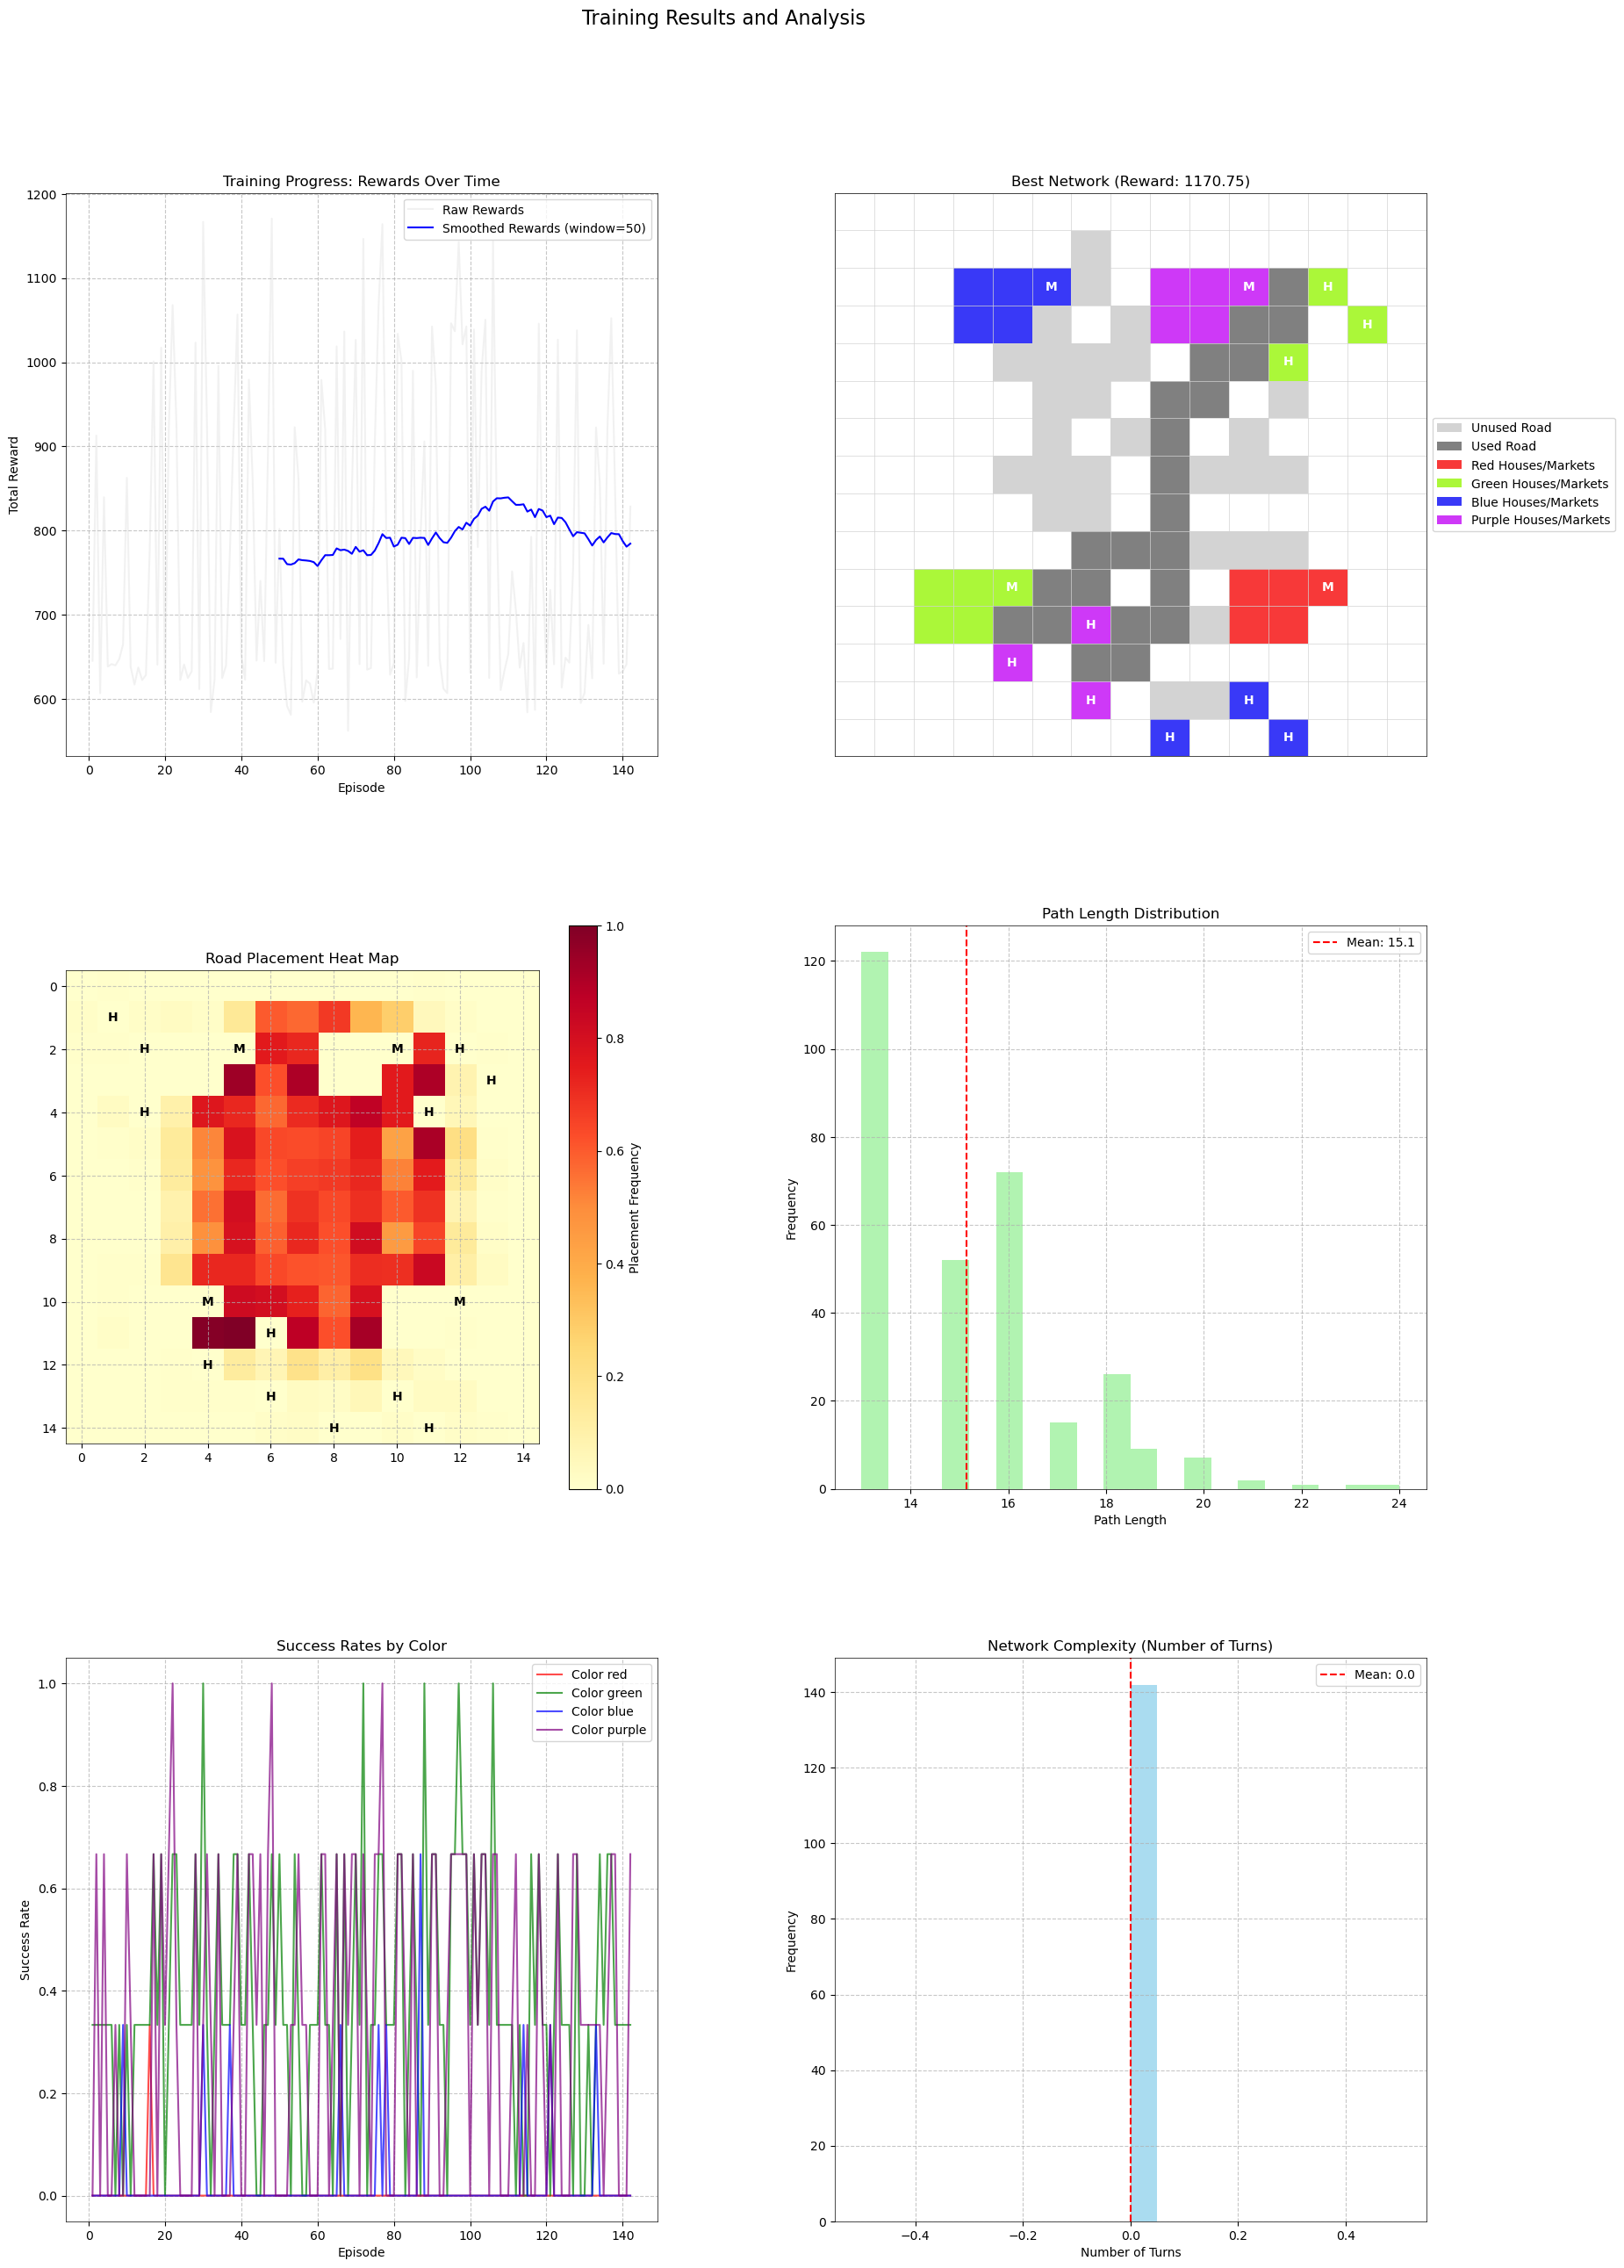

In [32]:
if trainer.best_network is not None:
    trainer.env.state = trainer.best_network.copy()
    trainer.env.update_used_roads()
    trainer.visualizer.plot_all(trainer.best_network, trainer.env, trainer.best_reward)

# Results
As seen in the rewards graph above, the model doesn't show any upwards trend as the episodes increment. This could be due to a few reasons:
1. Reward structure complexity
    - Multiple competing factors:
        - Placement rewards for road positioning
        - Performance rewards for traffic flow
        - Coverage rewards for valid paths
        - Various penalties for conflicts and waiting
    - This complex reward landscape might make it difficult for the DQN to learn clear patterns of improvement, as optimizing one aspect could hurt others.
2. Exploration vs Exploitation Balance
    - The epsilon decay of 1500 steps might be too aggressive for this complex environment
    - With epsilon_end at 0.05, the agent might be getting stuck in local optima too early
    - The tendril-based guided exploration helps, but could be limiting the agent's ability to discover radically different solutions
3. State space representation
    - The current CNN architecture might not be capturing the important spatial relationships effectively enough
    - The 5-channel representation (empty, road, house, market, entrance) doesn't explicitly encode:
        - Traffic flow patterns
        - Path efficiency metrics
        - Color-matching relationships between houses and markets
4. Architectural Limitations
    - The current CNN (3 conv layers + 2 FC layers) might not have enough capacity to learn the complex spatial patterns needed for optimal road placement
    - The network might benefit from attention mechanisms to better understand the relationships between houses and their matching markets


The rewards graph is heavily influenced by completed trips, so that may be severely limiting the agents ability to learn effective road placements. I found it interesting that every time I trained the model, it chose to draw roads diagonally from the bottom left to the top right. This could be an inherent trait of the environment placements, but I'm suprised it never found a strong network for blue and red.

Unfortunately, I ran out of time, so I don't have the ability to test these potential shortcomings. I'm still decently satisfied that everything works, and the model is able to find valid paths given the difficult environment setup. In the future, it would be interesting to try a purely CNN based model on the real game. If given enough gameplay footage, I wonder if it could learn anything. Some researchers have done this with Minecraft with suprising success, so I wonder if a simpler case could work with a simpler model.